In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from random import randint
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

c:\Users\Tom\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
data = pd.read_csv('Data/train.csv')
X, y = data.iloc[:, 1:].values.reshape(-1, 28, 28, 1), data.iloc[:, 0].values
X, X_test, y, y_test = train_test_split(X, y, test_size=0.1)
y = tf.keras.utils.to_categorical(y)

In [4]:
X = X / 255
X_test = X_test / 255

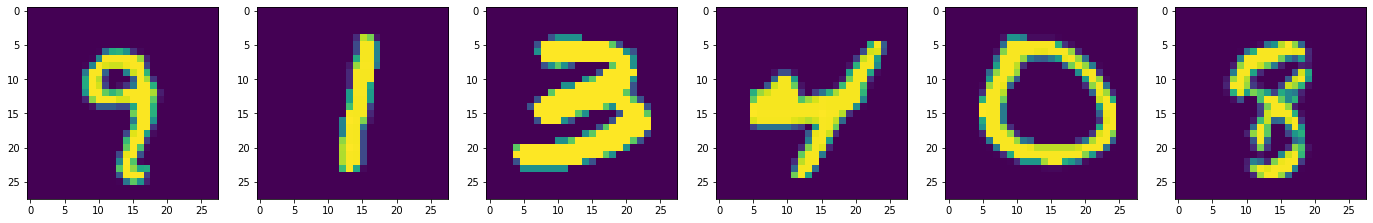

In [5]:
fig, ax = plt.subplots(figsize=(24, 6), ncols=6)

for i in range(6):
    ax[i].imshow(X[randint(0, X.shape[0])])

In [6]:
def get_model():

    data_augmentation = Sequential(
        [
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.1),
        ]
    )
    
    input_layer = layers.Input(shape=(28, 28, 1))
    data_aug = data_augmentation(input_layer)
    layer_1 = layers.Conv2D(32, kernel_size=3, activation='relu')(data_aug)
    layer_3 = layers.MaxPooling2D(pool_size=(2, 2))(layer_1)

    layer_4 = layers.Conv2D(64, kernel_size=3, activation='relu')(layer_3)
    layer_6 = layers.MaxPooling2D(pool_size=(2, 2))(layer_4)

    layer_7 = layers.Conv2D(128, kernel_size=3, activation='relu')(layer_6)
    layer_9 = layers.MaxPooling2D(pool_size=(2, 2))(layer_7)

    layer_10 = layers.Dropout(0.2)(layer_9)
    layer_11 = layers.Flatten()(layer_10)
    layer_12 = layers.Dense(100, activation='relu')(layer_11)
    layer_13 = layers.Dense(10, activation='sigmoid')(layer_12)

    model = Model(inputs=input_layer, outputs=layer_13)

    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

    return model

In [7]:
model = get_model()

In [8]:
model.fit(
    x=X,
    y=y,
    validation_split=0.05,
    batch_size=256,
    epochs=50
)

Epoch 1/50
141/141 [==============================] - 12s 20ms/step - loss: 0.2876 - accuracy: 0.3787 - val_loss: 0.0930 - val_accuracy: 0.8646
Epoch 2/50
141/141 [==============================] - 2s 16ms/step - loss: 0.1022 - accuracy: 0.8261 - val_loss: 0.0371 - val_accuracy: 0.9471
Epoch 3/50
141/141 [==============================] - 2s 12ms/step - loss: 0.0627 - accuracy: 0.8965 - val_loss: 0.0253 - val_accuracy: 0.9656
Epoch 4/50
141/141 [==============================] - 2s 13ms/step - loss: 0.0465 - accuracy: 0.9257 - val_loss: 0.0179 - val_accuracy: 0.9735
Epoch 5/50
141/141 [==============================] - 2s 14ms/step - loss: 0.0384 - accuracy: 0.9390 - val_loss: 0.0153 - val_accuracy: 0.9767
Epoch 6/50
141/141 [==============================] - 2s 15ms/step - loss: 0.0344 - accuracy: 0.9441 - val_loss: 0.0141 - val_accuracy: 0.9788
Epoch 7/50
141/141 [==============================] - 2s 17ms/step - loss: 0.0319 - accuracy: 0.9486 - val_loss: 0.0130 - val_accuracy: 0.981

### Using XGBoost Classifier as Top Level Model

In [9]:
xgb = XGBClassifier(n_jobs=-1, tree_method='gpu_hist', use_label_encoder=False, eval_metric='mlogloss')
feature_extraction_model = Model(inputs=model.input, outputs=model.layers[-2].output)

In [10]:
def train_xgb(
    feature_extraction_model: Model, 
    xgb: XGBClassifier, 
    X: np.ndarray, 
    y: np.ndarray
) -> XGBClassifier:
    """
    Train the XGBoost model on the outputs of the convnet

    Args:
        feature_extraction_model: Pretrained network with final layer being densely connected layer.
        xgb: XGBoost classifier to be fit to the data
    Outputs:
        Fitted XGBClassifier object
    """
    nn_output = feature_extraction_model.predict(X)
    y = np.argmax(y, axis=1)
    xgb = xgb.fit(nn_output, y)
    return xgb

def predict_xgb(
    feature_extraction_model: Model, 
    xgb: XGBClassifier, 
    X: np.ndarray
) -> np.ndarray:
    """
    Predict using the trained XGBClassifier object

    Args:
        feature_extraction_model: Pretrained network with final layer being densely connected layer.
        xgb: XGBoost classifier to be used for inference
    Outputs:
        Binary prediction array
    """
    nn_output = feature_extraction_model.predict(X)
    preds = xgb.predict(nn_output)
    return preds

In [11]:
xgb = train_xgb(feature_extraction_model, xgb, X, y)

In [12]:
ensemble_preds = predict_xgb(feature_extraction_model, xgb, X_test)
nn_preds = model.predict(X_test)

In [17]:
print("The accuracy of the neural network alone on the test set is {:.3%} and the accuracy of the stacked classifier is {:.3%}.".format(accuracy_score(y_test, nn_preds.argmax(axis=1)), accuracy_score(y_test, ensemble_preds)))

The accuracy of the neural network alone on the test set is 98.381% and the accuracy of the stacked classifier is 98.429%.
